In [1]:
import numpy as np
import torch
from torch import nn
import time
import matplotlib.pyplot as plt

MG_data = np.load('E:/ukf_data/Mackey_Glass/mgts_len=5000000tau=18n=10.0bet=0.25gam=0.1h=0.9T=1.npy', allow_pickle=True)
print(type(MG_data))
print(MG_data.shape)

<class 'numpy.ndarray'>
(5000000,)


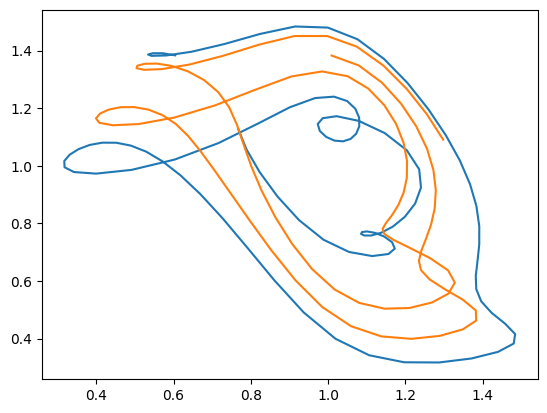

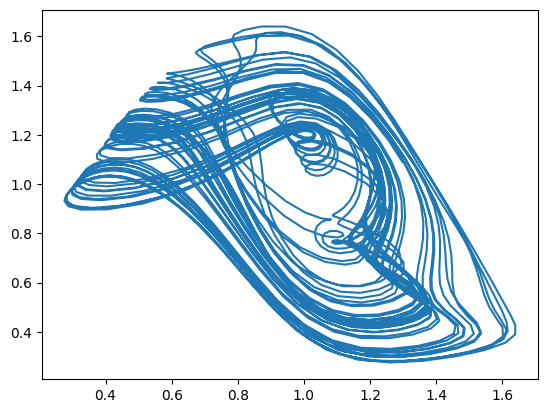

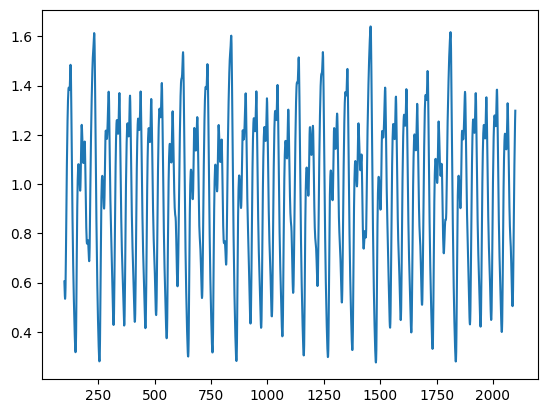

In [2]:
tau = 18
sample_start = 100
sample_len = 100
plt.plot(MG_data[sample_start:sample_start+sample_len], MG_data[sample_start + tau : sample_start+sample_len + tau])
sample_start = 2000
plt.plot(MG_data[sample_start:sample_start+sample_len], MG_data[sample_start + tau : sample_start+sample_len + tau])
plt.show()

sample_start = 100
sample_len = 2000
plt.plot(MG_data[sample_start:sample_start+sample_len], MG_data[sample_start + tau : sample_start+sample_len + tau])
plt.show()

plt.plot(range(sample_start, sample_start + sample_len), MG_data[sample_start:sample_start+sample_len])
plt.show()

In [3]:
from torch.utils.data import Dataset, DataLoader

class MacKey_Glass(Dataset):
    def __init__(self, data_path, 
                 data_len = 100000, 
                 start_point = 100000,
                 input_len = 6,
                 input_transform=None, 
                 target_transform=None
                 ):
        super(MacKey_Glass, self).__init__()
        self.data = np.load(data_path, allow_pickle= True).astype(np.float32)
        self.all_data_len = len(self.data)
        self.input_len = input_len
        self.data_len = data_len
        self.start_point = start_point

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        return self.data[idx : idx + self.input_len], self.data[idx + self.input_len]
    
data_path = 'E:/ukf_data/Mackey_Glass/mgts_len=5000000tau=18n=10.0bet=0.25gam=0.1h=0.9T=1.npy'

train_start = 100
train_len = 100
test_start = train_start + train_len
test_len = 10000

train_data = MacKey_Glass(data_path=data_path, data_len=train_len, start_point=train_start, input_len=6)
test_data = MacKey_Glass(data_path=data_path, data_len=test_len, start_point=test_start, input_len=6)

train_loader = DataLoader(train_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [4]:
def get_f(name: str = "tanh") -> nn.Module:
    activations = nn.ModuleDict(
        [
            ["lrelu", nn.LeakyReLU(0.1)],
            ["relu", nn.ReLU()],
            ["tanh", nn.Tanh()],
        ]
    )
    return activations[name]

def dense_block(layers : list(), activation: str) -> nn.Sequential:
    out = list()
    for idx, (in_f, out_f) in enumerate(zip(layers, layers[1:])):
        if idx == len(layers) - 2:
            out.append(nn.Linear(in_f, out_f, bias=False))
        else:
            out.append(nn.Linear(in_f, out_f))
            if activation is not None:
                out.append(get_f(activation))
    return nn.Sequential(*out)

class neural_network(nn.Module):
    def __init__(
            self,
            input_dim = 1025, 
            hidden_dim = 1000, 
            output_dim = 1025, 
            n_layers = 8,
            activation = 'relu' 
            ):
        super(neural_network, self).__init__()
        self.layers = [input_dim] + [hidden_dim] * n_layers + [output_dim]
        self.net = dense_block(self.layers, activation)

    def forward(self, x):
        
        return self.net(x)


In [5]:
model = neural_network(input_dim=6, hidden_dim=6, output_dim=1, n_layers=1, activation='tanh')
print(model.parameters)

# torch.save(model, 'recent_model.pt')

# model = ANN_Model('recent_model.pt', gpu_mode=False)
model = torch.load('recent_model.pt')
# print(model.parameters)

<bound method Module.parameters of neural_network(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=6, bias=True)
    (1): Tanh()
    (2): Linear(in_features=6, out_features=1, bias=False)
  )
)>


In [6]:
from scipy.linalg import cholesky, sqrtm

class MerweSigmaPoints(object):

    """
    Generates sigma points and weights according to the alpha, beta, kappa formulation of Van der Merwe.

    Parameters
    ----------
    n : int, dimensionality of the state. 2n+1 weights will be generated.

    ukf_params: parameters for computing sigma points

    sigma_method: string, method for computing sigma points

    sqrt_method : string, determines how the square root of a matrix is calculated.

    subtract : callable (x, y), optional, function that computes the difference between x and y.

    Attributes
    ----------
    Wm : np.array, weight for each sigma point for the mean
    Wc : np.array, weight for each sigma point for the covariance
    """

    def __init__(self, n, ukf_params, sigma_method=None, sqrt_method=None, subtract=None):

        self.n = n

        if sigma_method is None or sigma_method == 'merwe':
            self.alpha = ukf_params[0]
            self.beta = ukf_params[1]
            self.kappa = ukf_params[2]
        elif sqrt_method == 'julier':
            self.kappa = ukf_params[0]
        else:
            raise RuntimeError("Invalid method for computing sigma points. Valid options are 'merwe' or 'julier'.")

        if sqrt_method is None or sqrt_method == 'chol':
            self.msqrt = cholesky
        elif sqrt_method == 'sqrtm':
            self.msqrt = sqrtm
        else:
            raise RuntimeError("Invalid method for computing matrix square root. Valid options are 'chol' or 'sqrtm'.")

        if subtract is None:
            self.subtract = np.subtract
        else:
            self.subtract = subtract

        self._compute_weights()

    def num_sigmas(self):
        """ Number of sigma points for each variable in the state x"""

        return 2*self.n + 1

    def generate_sigmas(self, x, P):
        """
        Computes the sigma points for an unscented Kalman filter given the mean (x) and covariance(P) of the filter.
        Returns tuple of the sigma points and weights.

        Returns
        -------
        sigmas : np.array, of size (n, 2n+1), Two dimensional array of sigma points. Each column contains all of the
                sigmas for one dimension in the problem space. Ordered by Xi_0, Xi_{1..n}, Xi_{n+1..2n}.
        """

        if self.n != np.size(x):
            raise ValueError("expected size(x) {}, but size is {}".format(self.n, np.size(x)))

        n = self.n

        if np.isscalar(x):
            x = np.asarray([x])

        if np.isscalar(P):
            P = np.eye(n)*P
        else:
            P = np.atleast_2d(P)

        lambda_ = self.alpha**2 * (n + self.kappa) - n
        sqrt_P = self.msqrt((lambda_ + n)*P)

        sigmas = np.zeros((2*n+1, n))
        sigmas[0] = x
        for k in range(n):
            sigmas[k+1] = self.subtract(x, -sqrt_P[k])
            sigmas[n+k+1] = self.subtract(x, sqrt_P[k])

        return sigmas

    def _compute_weights(self):
        """ Computes the weights for the scaled unscented Kalman filter.
        """
        n = self.n
        lambda_ = self.alpha ** 2 * (n + self.kappa) - n
        c = .5 / (n + lambda_)
        self.Wc = np.full(2 * n + 1, c)
        self.Wm = np.full(2 * n + 1, c)
        self.Wc[0] = lambda_ / (n + lambda_) + (1 - self.alpha ** 2 + self.beta)
        self.Wm[0] = lambda_ / (n + lambda_)

In [13]:
from functools import partial
from copy import deepcopy

def unscented_transform(sigmas, w_mean, w_cov, noise_cov=None, mean_fn=None, residual_fn=None):
    """
    Computes unscented transform of a set of sigma points and weights. returns the mean and covariance in a tuple.
    This works in conjunction with the UnscentedKF class.

    Parameters
    ----------
    sigmas: ndarray, of size (n, 2n+1), 2D array of sigma points.

    w_mean : ndarray [# sigmas per dimension], Weights for the mean.

    w_cov : ndarray [# sigmas per dimension], Weights for the covariance.

    noise_cov : ndarray, optional, noise matrix added to the final computed covariance matrix.

    mean_fn : callable (sigma_points, weights), optional

    residual_fn : callable (x, y)

    Returns
    -------
    x : ndarray [dimension], Mean of the sigma points after passing through the transform.

    P : ndarray, covariance of the sigma points after passing throgh the transform.

    """

    num_sig, num_st = len(sigmas), len(sigmas[0])
    if mean_fn is None:
        # new mean is just the sum of the sigmas * weight
        x = np.dot(w_mean, sigmas)    # dot = \Sigma^n_1 (W[k]*Xi[k]),
    else:
        x = mean_fn(sigmas, w_mean)

    # new covariance is the sum of the outer product of the residuals times the weights
    if residual_fn is np.subtract or residual_fn is None:
        y = sigmas - x[np.newaxis, :] # shape = sigma.shape, 
        P = np.dot(y.T, np.dot(np.diag(w_cov), y)) # shape = (num_st * num_st)
    else:
        P = np.zeros((num_st, num_st))
        for k in range(num_sig):
            y = residual_fn(sigmas[k], x)
            P += w_cov[k] * np.outer(y, y)

    if noise_cov is not None:
        if np.isscalar(noise_cov):
            P += noise_cov * np.eye(P.shape[0])
        else:
            P += noise_cov

    return x, P

In [14]:
def output_with_each_sigma_point(
        model : nn.Module,
        params,
        data_loader
        ):

    state_dicts = model.state_dict()
    idx = 0
    for p, k in zip(model.parameters(), model.state_dict().keys()):
        if p.requires_grad == True:
            l = len(p.flatten())
            state_dicts[k] = torch.nn.Parameter(torch.from_numpy(params[idx : idx + l].reshape(p.shape)))
            idx += l
    model.load_state_dict(state_dicts)

    for i, t in data_loader:
        output = model(i)
        break

    return output.flatten().detach().numpy()

In [15]:
class UKF(object):
    def __init__(self, dim_x, dim_y, fx, hx, ukf_params, x_mean_fn, y_mean_fn, init_x):
        self.x = np.zeros(dim_x)
        self.x = np.array(init_x)

        self.P = np.eye(dim_x)
        self.x_pred = np.copy(self.x)
        self.P_pred = np.copy(self.P)
        self.Q = np.eye(dim_x)
        self.R = np.eye(dim_y)
        self._dim_x = dim_x
        self._dim_y = dim_y
        self._ukf_params = ukf_params

        self.x_mean = x_mean_fn
        self.y_mean = y_mean_fn
        self._fx = fx
        self._hx = hx

        sig_pts = MerweSigmaPoints(dim_x, ukf_params)
        # weights for the means and covariances.
        self.sigma_points = sig_pts
        self.Wm, self.Wc = sig_pts.Wm, sig_pts.Wc
        self._num_sigmas = sig_pts.num_sigmas() # 2n + 1

        # sigma points transformed through f(x) and h(x). variables for efficiency so we don't recreate every update
        self.sigmas_f = np.zeros((self._num_sigmas, self._dim_x))
        self.sigmas_h = np.zeros((self._num_sigmas, self._dim_y))
        self.residual_x = np.subtract
        self.residual_y = np.subtract

        self.K = np.zeros((dim_x, dim_y)) # Kalman Gain
        self.innov = np.zeros(dim_y)
        self.y = np.array([[None] * dim_y]).T

        self.S = np.zeros((dim_y, dim_y))  # system uncertainty
        self.SI = np.zeros((dim_y, dim_y))  # inverse system uncertainty
        self.inv = np.linalg.inv

        # these will always be a copy of x, P after predict() is called
        self.x_pred = self.x.copy()
        self.P_pred = self.P.copy()

        # these will always be a copy of x, P after update() is called
        self.x_updt = self.x.copy()
        self.P_updt = self.P.copy()


    def predict(self):
        self.compute_process_sigmas()
        self.x, self.P = unscented_transform(self.sigmas_f, self.Wm, self.Wc, self.Q, self.x_mean, self.residual_x)
        
        # save prior
        self.x_pred = np.copy(self.x)
        self.P_pred = np.copy(self.P)

    def update(self, y, data_loader):
        if y is None:
            self.y = np.array([[None] * self._dim_y]).T
            self.x_updt = self.x.copy()
            self.P_updt = self.P.copy()
            return

        if np.isscalar(self.R):
            R = np.eye(self._dim_y) * self.R
        else:
            R = self.R

        sigmas_h = []
        for s in self.sigmas_f:
            # pass neural network with sigma_points parameters
            sigmas_h.append(output_with_each_sigma_point(self._hx, s, data_loader))

        yp, self.S = unscented_transform(sigmas_h, self.Wm, self.Wc, R, self.y_mean, self.residual_y)
        self.SI = self.inv(self.S)

        # compute cross variance of the state and the measurements
        Pxy = self.cross_variance(self.x, yp, self.sigmas_f, sigmas_h)
        self.K = np.dot(Pxy, self.SI)  # Kalman gain

        self.y = self.residual_y(y, yp)  # residual

        # update Gaussian state estimate (x, P)
        self.x = self.x + np.dot(self.K, self.y)
        self.P = self.P - np.dot(self.K, np.dot(self.S, self.K.T))

        # save measurement and posterior state
        # self.y = deepcopy(y)
        self.x_updt = self.x.copy()
        self.P_updt = self.P.copy()

    def cross_variance(self, x, y, sigmas_f, sigmas_h):
        """
        Compute cross variance of the state `x` and measurement `y`.
        """

        Pxy = np.zeros((sigmas_f.shape[1], len(sigmas_h[0])))
        N = sigmas_f.shape[0]
        for i in range(N):
            dx = self.residual_x(sigmas_f[i], x)
            dy = self.residual_y(sigmas_h[i], y)
            Pxy += self.Wc[i] * np.outer(dx, dy)
        return Pxy

    def compute_process_sigmas(self):
        fx = self._fx
        # calculate sigma points for given mean and covariance
        sigmas = self.sigma_points.generate_sigmas(self.x, self.P)

        for i, s in enumerate(sigmas):
            self.sigmas_f[i] = fx(s) # num_sigmax * dim_x

    def return_weight(self):
        return self.x_updt
    
    def return_loss(self):
        return np.sum(np.abs(self.y)) / self._dim_y

In [17]:
def fx(x):
    # Nothing to do here. Process Model is random walk
    return x

def model_update_ukf(data_loader,ukf_params,model : nn.Module,max_iter : int = 40):
    learnable_params = list()
    for p, k in zip(model.parameters(), model.state_dict().keys()):
        if p.requires_grad == True:
            learnable_params.extend(model.state_dict()[k].flatten().tolist())
    state_dicts = model.state_dict()
    
    loss_history = list()

    for i, t in data_loader:
        ukf = UKF(dim_x = len(learnable_params), dim_y = data_loader.batch_size, 
                fx = fx, hx = model, ukf_params=ukf_params, x_mean_fn=None, y_mean_fn=None, init_x=learnable_params)
        ukf.P = 0.001
        ukf.Q = 0.001
        ukf.R = 0.001

        t = t.flatten().detach().numpy()
        for iter in range(max_iter):
            # print('Iteration: ', iter + 1)
            # print('Initial State at this iteration', ukf.x)
            ukf.predict()
            ukf.update(t, data_loader)
            # print('Updated State at this iteration', ukf.x)

            loss_history.append(ukf.return_loss())
        break

    learned_params = ukf.return_weight()

    idx = 0
    for p, k in zip(model.parameters(), model.state_dict().keys()):
        if p.requires_grad == True:
            l = len(p.flatten())
            state_dicts[k] = torch.nn.Parameter(torch.from_numpy(learned_params[idx : idx + l].reshape(p.shape)))
            idx += l
    model.load_state_dict(state_dicts)
    return model, loss_history

In [18]:
model = torch.load('recent_model.pt')

for i, t in train_loader:
    output = model(i)
    
    break

print(f'Loss before train : {sum(torch.abs(output.squeeze() - t)).item() / 64}')

# print(model.state_dict())
print()

model, loss_history = model_update_ukf(model = model, max_iter = 40, data_loader = train_loader, ukf_params=[1,2,0])

# print(model.state_dict())
for i, t in train_loader:
    output = model(i)
    
    break

print(f'Loss after train : {sum(torch.abs(output.squeeze() - t)).item() / 64}')

Loss before train : 1.139790654182434

Loss after train : 0.04045195132493973


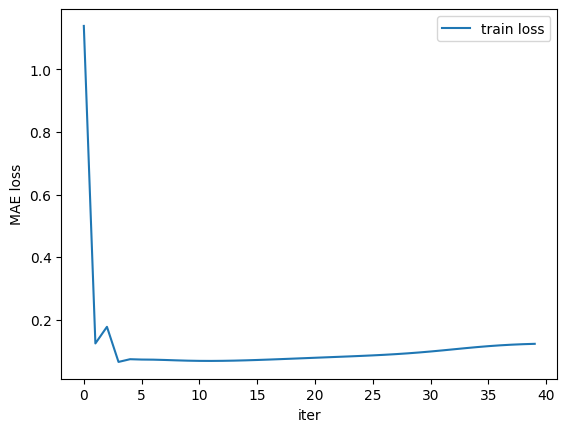

In [21]:
plt.plot(range(40), loss_history, label = 'train loss')
plt.xlabel('iter')
plt.ylabel('MAE loss')
plt.legend()
plt.show()